# Figure Refine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import bisect
import time, argparse
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.stats import zscore
from scipy.sparse import coo_matrix
from utilities import mkdir
from utils.io import compactM

In [3]:
from visual_tad import *
from utils.viz import heatmap

In [4]:
work_dir = '/data/RaoHiC/results/MISC'
mkdir(work_dir)

In [5]:
file = '/data/RaoHiC/predict/GM12878/predict_chr22_40kb.npz'

In [6]:
bs_h=10; bs_w=2; bi_size=17; offset=2; is_size=10; delta_width=5

In [7]:
chrn = 22
data = np.load(file)
print(f'Reading {file}')

Reading /data/RaoHiC/predict/GM12878/predict_chr22_40kb.npz


In [8]:
orighic = compactM(data['hic'], data['compact'], verbose=True)
deephic = compactM(data['deephic'], data['compact'], verbose=True)
plushic = compactM(data['hicplus'], data['compact'], verbose=True)
downhic = compactM(data['downhic'], data['compact'], verbose=True)

Compacting a (5136, 5136) shaped matrix to (3350, 3350) shaped!
Compacting a (5136, 5136) shaped matrix to (3350, 3350) shaped!
Compacting a (5136, 5136) shaped matrix to (3350, 3350) shaped!
Compacting a (5136, 5136) shaped matrix to (3350, 3350) shaped!


In [9]:
orighic = zscore_hic(orighic)
deephic = zscore_hic(deephic)
plushic = zscore_hic(plushic)
downhic = zscore_hic(downhic)

In [10]:
orig_bs = boundary_score(orighic, bs_h, bs_w)
down_bs = boundary_score(downhic, bs_h, bs_w)
plus_bs = boundary_score(plushic, bs_h, bs_w)
deep_bs = boundary_score(deephic, bs_h, bs_w)

In [11]:
orig_bi = boundary_intensity(orighic, bi_size)
down_bi = boundary_intensity(downhic, bi_size)
plus_bi = boundary_intensity(plushic, bi_size)
deep_bi = boundary_intensity(deephic, bi_size)

In [12]:
orig_bs_zero = zero_points(orig_bs)
down_bs_zero = zero_points(down_bs)
plus_bs_zero = zero_points(plus_bs)
deep_bs_zero = zero_points(deep_bs)

In [13]:
down_bs_dists = min_dist(orig_bs_zero, down_bs_zero)
plus_bs_dists = min_dist(orig_bs_zero, plus_bs_zero)
deep_bs_dists = min_dist(orig_bs_zero, deep_bs_zero)

In [14]:
down_bs_jacrd = count_overlap(orig_bs_zero, down_bs_zero)
plus_bs_jacrd = count_overlap(orig_bs_zero, plus_bs_zero)
deep_bs_jacrd = count_overlap(orig_bs_zero, deep_bs_zero)

In [15]:
orig_is = insulation_score(orighic, offset, is_size)
down_is = insulation_score(downhic, offset, is_size)
plus_is = insulation_score(plushic, offset, is_size)
deep_is = insulation_score(deephic, offset, is_size)

In [16]:
orig_isd = score_delta(orig_is, delta_width)
down_isd = score_delta(down_is, delta_width)
plus_isd = score_delta(plus_is, delta_width)
deep_isd = score_delta(deep_is, delta_width)

In [17]:
orig_is_zero = zero_points(orig_isd, orient='ascent')
down_is_zero = zero_points(down_isd, orient='ascent')
plus_is_zero = zero_points(plus_isd, orient='ascent')
deep_is_zero = zero_points(deep_isd, orient='ascent')

In [18]:
down_is_dists = min_dist(orig_is_zero, down_is_zero)
plus_is_dists = min_dist(orig_is_zero, plus_is_zero)
deep_is_dists = min_dist(orig_is_zero, deep_is_zero)

In [19]:
down_is_jacrd = count_overlap(orig_is_zero, down_is_zero)
plus_is_jacrd = count_overlap(orig_is_zero, plus_is_zero)
deep_is_jacrd = count_overlap(orig_is_zero, deep_is_zero)

In [20]:
def plot_scores(ax, orig, down, plus, deep, start=1400, end=1600, close_ticks=False):
    ax.plot(range(start, end), orig_isd[start:end], label='Experimental', color='C2')
    ax.plot(range(start, end), down_isd[start:end], label='Downsampled', color='C5')
    ax.plot(range(start, end), plus_isd[start:end], label='HiCplus', color='C0')
    ax.plot(range(start, end), deep_isd[start:end], label='DeepHiC', color='C1')
    ax.plot(range(start, end), np.zeros(end-start), color='gray', linestyle='--')
    if close_ticks:
        ax.set_yticks([])
        ax.set_xticks([])

In [21]:
fillcolor = (191. / 255., 209. / 256., 212. / 255.)

In [22]:
def add_arrow(ax, xy, xytext, arrowprops):
    ax.annotate("", xy=xy, xycoords='axes fraction', xytext=xytext, textcoords='axes fraction', arrowprops=arrowprops)

## Fig. 4A

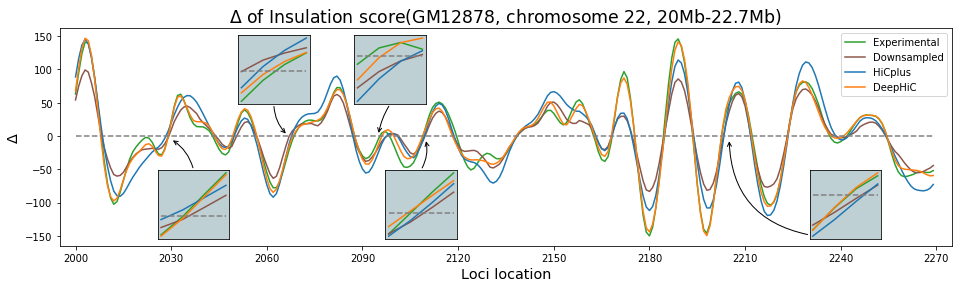

In [23]:
fig, ax = plt.subplots(figsize=[16, 4])
start, end = 2000, 2270
plot_scores(ax, orig_isd, down_isd, plus_isd, deep_isd, start=start, end=end)
ax.set_xlim(left=start-5, right=end+5)
ax.set_xlabel('Loci location', fontsize='x-large')
ax.set_xticks([2000, 2030, 2060, 2090, 2120, 2150, 2180, 2210, 2240, 2270])
ax.set_ylabel('$\Delta$', fontsize='x-large')
ax.set_title('$\Delta$ of Insulation score(GM12878, chromosome 22, 20Mb-22.7Mb)', fontsize='xx-large')
ax.legend(loc='upper right')

## First embedding box
start, end = 2028, 2032
iax1 = ax.inset_axes([.11, .03, .08, .32], facecolor=fillcolor)
plot_scores(iax1, orig_isd, down_isd, plus_isd, deep_isd, start=start, end=end, close_ticks=True)
add_arrow(ax, xy=(0.125, 0.49), xytext=(0.15, 0.35), arrowprops=dict(facecolor=fillcolor, arrowstyle="->",connectionstyle="arc3,rad=0.2"))
## Second embedding box
start, end = 2067, 2071
iax1 = ax.inset_axes([.2, .65, .08, .32], facecolor=fillcolor)
plot_scores(iax1, orig_isd, down_isd, plus_isd, deep_isd, start=start, end=end, close_ticks=True)
add_arrow(ax, xy=(0.255, 0.51), xytext=(0.24, 0.65), arrowprops=dict(facecolor=fillcolor, arrowstyle="->",connectionstyle="arc3,rad=0.2"))
## Third embedding box
start, end = 2095, 2099
iax1 = ax.inset_axes([.33, .65, .08, .32], facecolor=fillcolor)
plot_scores(iax1, orig_isd, down_isd, plus_isd, deep_isd, start=start, end=end, close_ticks=True)
add_arrow(ax, xy=(0.357, 0.51), xytext=(0.37, 0.65), arrowprops=dict(facecolor=fillcolor, arrowstyle="->",connectionstyle="arc3,rad=0.1"))
## Fourth embedding box
start, end = 2108, 2112
iax1 = ax.inset_axes([.365, .03, .08, .32], facecolor=fillcolor)
plot_scores(iax1, orig_isd, down_isd, plus_isd, deep_isd, start=start, end=end, close_ticks=True)
add_arrow(ax, xy=(0.41, 0.49), xytext=(0.405, 0.35), arrowprops=dict(facecolor=fillcolor, arrowstyle="->",connectionstyle="arc3,rad=0.2"))

start, end = 2201, 2205
iax1 = ax.inset_axes([.84, .03, .08, .32], facecolor=fillcolor)
plot_scores(iax1, orig_isd, down_isd, plus_isd, deep_isd, start=start, end=end, close_ticks=True)
add_arrow(ax, xy=(0.75, 0.49), xytext=(0.84, 0.05), arrowprops=dict(facecolor=fillcolor, arrowstyle="->",connectionstyle="arc3,rad=-0.4"))

svg_file = os.path.join(work_dir, f'fig4a_is.svg')
eps_file = os.path.join(work_dir, f'fig4a_is.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')

In [24]:
from scipy.stats import pearsonr

In [25]:
pearsonr(orig_isd[2000:2270], deep_isd[2000:2270])

(0.9920287721684103, 3.989407738902606e-243)

In [26]:
pearsonr(orig_isd[2000:2270], down_isd[2000:2270])

(0.9525413356159136, 1.8842125635957807e-140)

In [27]:
pearsonr(orig_isd[2000:2270], plus_isd[2000:2270])

(0.9365998146582654, 4.562091868715259e-124)

## Fig. 4BCD

In [5]:
def tad_analysis(file, delta_width=5):
    scores = np.loadtxt(file)
    orig_is = scores[:, 0]
    down_is = scores[:, 1]
    plus_is = scores[:, 2]
    deep_is = scores[:, 3]
    # calculation the delta of insulation score
    orig_isd = score_delta(orig_is, delta_width)
    down_isd = score_delta(down_is, delta_width)
    plus_isd = score_delta(plus_is, delta_width)
    deep_isd = score_delta(deep_is, delta_width)
    # find zero_points in insulation score
    orig_is_zero = zero_points(orig_isd, orient='ascent')
    down_is_zero = zero_points(down_isd, orient='ascent')
    plus_is_zero = zero_points(plus_isd, orient='ascent')
    deep_is_zero = zero_points(deep_isd, orient='ascent')
    # count minimal distance of segments
    down_is_dists = min_dist(orig_is_zero, down_is_zero)
    plus_is_dists = min_dist(orig_is_zero, plus_is_zero)
    deep_is_dists = min_dist(orig_is_zero, deep_is_zero)
    # count jaccard index of segments
    down_is_jacrd = count_overlap(orig_is_zero, down_is_zero)
    plus_is_jacrd = count_overlap(orig_is_zero, plus_is_zero)
    deep_is_jacrd = count_overlap(orig_is_zero, deep_is_zero)
    
    # prepare return values
    is_zeros = (orig_is_zero, down_is_zero, plus_is_zero, deep_is_zero)
    is_dists = (down_is_dists, plus_is_dists, deep_is_dists)
    is_jacrd = (down_is_jacrd, plus_is_jacrd, deep_is_jacrd)
    return is_zeros, is_dists, is_jacrd

In [6]:
chr_list = list(range(1,23)) + ['X']

In [7]:
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [8]:
results_gm12878 = []
for chr_num in chr_list:
    file = f'/data/RaoHiC/results/GM12878/40kb/visual/tad_analysis/data/chr{chr_num}_insulation_score_compact.csv'
    results_gm12878.append(tad_analysis(file))

is_zeros, is_dists, is_jacrd = zip(*results_gm12878)
orig_zero, down_zero, plus_zero, deep_is_zero = zip(*is_zeros)
down_dists, plus_dists, deep_dists = zip(*is_dists)
down_jacrd, plus_jacrd, deep_jacrd = zip(*is_jacrd)

down_dist_mean = [np.mean(arr) for arr in down_dists]
plus_dist_mean = [np.mean(arr) for arr in plus_dists]
deep_dist_mean = [np.mean(arr) for arr in deep_dists]

In [9]:
down_dists_all = np.concatenate(down_dists, axis=0)
plus_dists_all = np.concatenate(plus_dists, axis=0)
deep_dists_all = np.concatenate(deep_dists, axis=0)

In [10]:
down_jacrd_all = np.concatenate(down_jacrd, axis=0)
plus_jacrd_all = np.concatenate(plus_jacrd, axis=0)
deep_jacrd_all = np.concatenate(deep_jacrd, axis=0)

In [11]:
label = ['Downsampled'] * 23 + ['HiCPlus'] * 23 + ['DeepHiC'] * 23
data = np.concatenate((down_dist_mean, plus_dist_mean, deep_dist_mean))
data_pd = pd.DataFrame({'data': data, 'label': label})

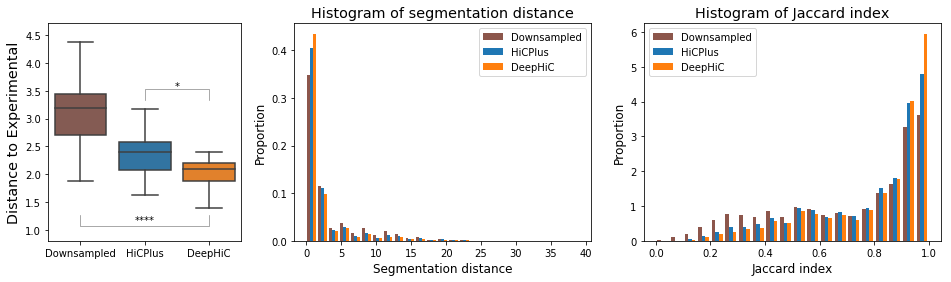

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(16,4), gridspec_kw = {'width_ratios':[1.3, 2, 2]})

pal = {'Downsampled': 'C5', 'HiCPlus': 'C0', 'DeepHiC': 'C1'}
sns.boxplot(x='label', y='data', data=data_pd, ax=ax[0], fliersize=0, palette=pal)
# ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('Distance to Experimental', fontsize='x-large')
y_max = 3.3
y_min = 0.5
ax[0].annotate("", xy=(1, y_max), xycoords='data',
           xytext=(2, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
ax[0].text(1.5, y_max + abs(y_max - y_min)*0.1, "*",
       horizontalalignment='center',
       verticalalignment='center')

y_max = 1.3
y_min = 0.1
ax[0].annotate("", xy=(0, y_max), xycoords='data',
           xytext=(2, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=-0.1"))
ax[0].text(1, y_max - abs(y_max - y_min)*0.1, "****",
       horizontalalignment='center',
       verticalalignment='center')


plot_hists(ax[1], down_dists_all, plus_dists_all, deep_dists_all, bins=25, 
           xlabel='Segmentation distance', ylabel='Proportion', 
           title='Histogram of segmentation distance')

plot_hists(ax[2], down_jacrd_all[:,1], plus_jacrd_all[:,1], deep_jacrd_all[:,1], bins=20, 
           xlabel='Jaccard index', ylabel='Proportion', 
           title='Histogram of Jaccard index')

svg_file = os.path.join(work_dir, f'fig4bcd_tad.svg')
eps_file = os.path.join(work_dir, f'fig4bcd_tad.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')

In [37]:
stats.ranksums(down_dist_mean, deep_dist_mean)

RanksumsResult(statistic=4.382851519637492, pvalue=1.1713594962179803e-05)

In [38]:
stats.ranksums(plus_dist_mean, deep_dist_mean)

RanksumsResult(statistic=2.2957793674291627, pvalue=0.021688499733200837)

# Supplementary

## GM12878R

In [39]:
results_gm12878 = []
for chr_num in chr_list:
    file = f'/data/RaoHiC/results/GM12878R/40kb/visual/tad_analysis/data/chr{chr_num}_insulation_score_compact.csv'
    results_gm12878.append(tad_analysis(file))

is_zeros, is_dists, is_jacrd = zip(*results_gm12878)
orig_zero, down_zero, plus_zero, deep_is_zero = zip(*is_zeros)
down_dists, plus_dists, deep_dists = zip(*is_dists)
down_jacrd, plus_jacrd, deep_jacrd = zip(*is_jacrd)

down_dist_mean = [np.mean(arr) for arr in down_dists]
plus_dist_mean = [np.mean(arr) for arr in plus_dists]
deep_dist_mean = [np.mean(arr) for arr in deep_dists]

In [40]:
down_dists_all = np.concatenate(down_dists, axis=0)
plus_dists_all = np.concatenate(plus_dists, axis=0)
deep_dists_all = np.concatenate(deep_dists, axis=0)

In [41]:
down_jacrd_all = np.concatenate(down_jacrd, axis=0)
plus_jacrd_all = np.concatenate(plus_jacrd, axis=0)
deep_jacrd_all = np.concatenate(deep_jacrd, axis=0)

In [42]:
label = ['Downsampled'] * 23 + ['HiCPlus'] * 23 + ['DeepHiC'] * 23
data = np.concatenate((down_dist_mean, plus_dist_mean, deep_dist_mean))
data_pd = pd.DataFrame({'data': data, 'label': label})

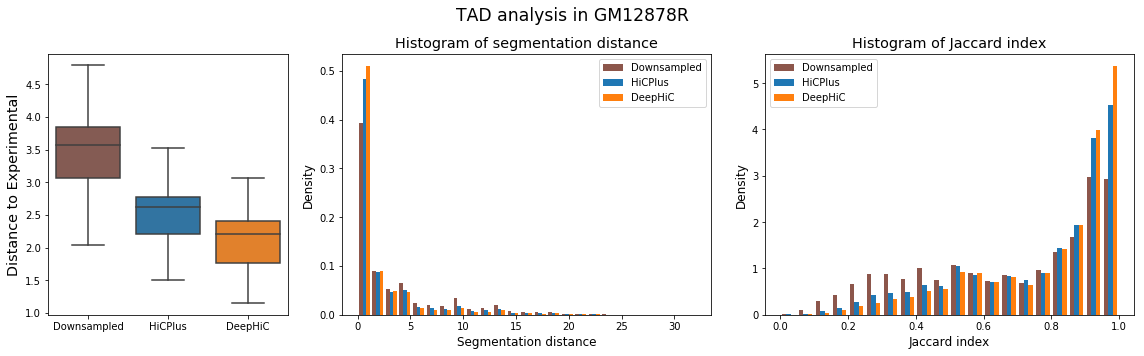

In [43]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5), gridspec_kw = {'width_ratios':[1.3, 2, 2]})

pal = {'Downsampled': 'C5', 'HiCPlus': 'C0', 'DeepHiC': 'C1'}
sns.boxplot(x='label', y='data', data=data_pd, ax=ax[0], fliersize=0, palette=pal)
# ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('Distance to Experimental', fontsize='x-large')
# y_max = 3.3
# y_min = 0.5
# ax[0].annotate("", xy=(1, y_max), xycoords='data',
#            xytext=(2, y_max), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# ax[0].text(1.5, y_max + abs(y_max - y_min)*0.1, "*",
#        horizontalalignment='center',
#        verticalalignment='center')

# y_max = 1.3
# y_min = 0.1
# ax[0].annotate("", xy=(0, y_max), xycoords='data',
#            xytext=(2, y_max), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=-0.1"))
# ax[0].text(1, y_max - abs(y_max - y_min)*0.1, "****",
#        horizontalalignment='center',
#        verticalalignment='center')


plot_hists(ax[1], down_dists_all, plus_dists_all, deep_dists_all, bins=25, 
           xlabel='Segmentation distance', ylabel='Density', 
           title='Histogram of segmentation distance')

plot_hists(ax[2], down_jacrd_all[:,1], plus_jacrd_all[:,1], deep_jacrd_all[:,1], bins=20, 
           xlabel='Jaccard index', ylabel='Density', 
           title='Histogram of Jaccard index')
fig.tight_layout()
plt.subplots_adjust(top=0.85)
fig.suptitle('TAD analysis in GM12878R', fontsize='xx-large')
svg_file = os.path.join(work_dir, f'supp_fig_tad_gm12878r.svg')
eps_file = os.path.join(work_dir, f'supp_fig_tad_gm12878r.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')

In [44]:
stats.ranksums(down_dist_mean, deep_dist_mean)

RanksumsResult(statistic=4.734358408430474, pvalue=2.1974911351156207e-06)

In [45]:
stats.ranksums(plus_dist_mean, deep_dist_mean)

RanksumsResult(statistic=2.141995103582233, pvalue=0.03219387604758206)

## K562

In [46]:
results_gm12878 = []
for chr_num in chr_list:
    file = f'/data/RaoHiC/results/K562/40kb/visual/tad_analysis/data/chr{chr_num}_insulation_score_compact.csv'
    results_gm12878.append(tad_analysis(file))

is_zeros, is_dists, is_jacrd = zip(*results_gm12878)
orig_zero, down_zero, plus_zero, deep_is_zero = zip(*is_zeros)
down_dists, plus_dists, deep_dists = zip(*is_dists)
down_jacrd, plus_jacrd, deep_jacrd = zip(*is_jacrd)

down_dist_mean = [np.mean(arr) for arr in down_dists]
plus_dist_mean = [np.mean(arr) for arr in plus_dists]
deep_dist_mean = [np.mean(arr) for arr in deep_dists]

In [47]:
down_dists_all = np.concatenate(down_dists, axis=0)
plus_dists_all = np.concatenate(plus_dists, axis=0)
deep_dists_all = np.concatenate(deep_dists, axis=0)

In [48]:
down_jacrd_all = np.concatenate(down_jacrd, axis=0)
plus_jacrd_all = np.concatenate(plus_jacrd, axis=0)
deep_jacrd_all = np.concatenate(deep_jacrd, axis=0)

In [49]:
label = ['Downsampled'] * 23 + ['HiCPlus'] * 23 + ['DeepHiC'] * 23
data = np.concatenate((down_dist_mean, plus_dist_mean, deep_dist_mean))
data_pd = pd.DataFrame({'data': data, 'label': label})

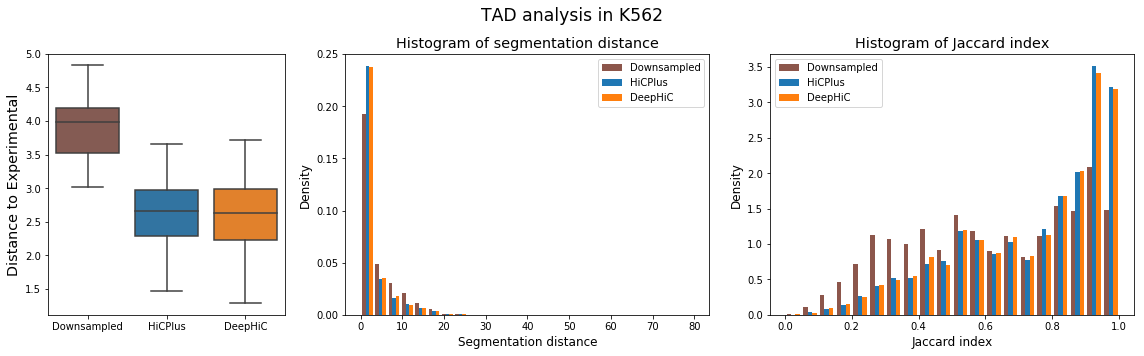

In [50]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5), gridspec_kw = {'width_ratios':[1.3, 2, 2]})

pal = {'Downsampled': 'C5', 'HiCPlus': 'C0', 'DeepHiC': 'C1'}
sns.boxplot(x='label', y='data', data=data_pd, ax=ax[0], fliersize=0, palette=pal)
# ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('Distance to Experimental', fontsize='x-large')
# y_max = 3.3
# y_min = 0.5
# ax[0].annotate("", xy=(1, y_max), xycoords='data',
#            xytext=(2, y_max), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# ax[0].text(1.5, y_max + abs(y_max - y_min)*0.1, "*",
#        horizontalalignment='center',
#        verticalalignment='center')

# y_max = 1.3
# y_min = 0.1
# ax[0].annotate("", xy=(0, y_max), xycoords='data',
#            xytext=(2, y_max), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=-0.1"))
# ax[0].text(1, y_max - abs(y_max - y_min)*0.1, "****",
#        horizontalalignment='center',
#        verticalalignment='center')


plot_hists(ax[1], down_dists_all, plus_dists_all, deep_dists_all, bins=25, 
           xlabel='Segmentation distance', ylabel='Density', 
           title='Histogram of segmentation distance')

plot_hists(ax[2], down_jacrd_all[:,1], plus_jacrd_all[:,1], deep_jacrd_all[:,1], bins=20, 
           xlabel='Jaccard index', ylabel='Density', 
           title='Histogram of Jaccard index')
fig.tight_layout()
plt.subplots_adjust(top=0.85)
fig.suptitle('TAD analysis in K562', fontsize='xx-large')
svg_file = os.path.join(work_dir, f'supp_fig_tad_k562.svg')
eps_file = os.path.join(work_dir, f'supp_fig_tad_k562.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')

In [51]:
stats.ranksums(down_dist_mean, deep_dist_mean)

RanksumsResult(statistic=4.36088233908793, pvalue=1.2953901447173344e-05)

In [52]:
stats.ranksums(plus_dist_mean, deep_dist_mean)

RanksumsResult(statistic=0.09886131247302614, pvalue=0.9212483865509821)

## IMR90

In [53]:
results_gm12878 = []
for chr_num in chr_list:
    file = f'/data/RaoHiC/results/IMR90/40kb/visual/tad_analysis/data/chr{chr_num}_insulation_score_compact.csv'
    results_gm12878.append(tad_analysis(file))

is_zeros, is_dists, is_jacrd = zip(*results_gm12878)
orig_zero, down_zero, plus_zero, deep_is_zero = zip(*is_zeros)
down_dists, plus_dists, deep_dists = zip(*is_dists)
down_jacrd, plus_jacrd, deep_jacrd = zip(*is_jacrd)

down_dist_mean = [np.mean(arr) for arr in down_dists]
plus_dist_mean = [np.mean(arr) for arr in plus_dists]
deep_dist_mean = [np.mean(arr) for arr in deep_dists]

In [54]:
down_dists_all = np.concatenate(down_dists, axis=0)
plus_dists_all = np.concatenate(plus_dists, axis=0)
deep_dists_all = np.concatenate(deep_dists, axis=0)

In [55]:
down_jacrd_all = np.concatenate(down_jacrd, axis=0)
plus_jacrd_all = np.concatenate(plus_jacrd, axis=0)
deep_jacrd_all = np.concatenate(deep_jacrd, axis=0)

In [56]:
label = ['Downsampled'] * 23 + ['HiCPlus'] * 23 + ['DeepHiC'] * 23
data = np.concatenate((down_dist_mean, plus_dist_mean, deep_dist_mean))
data_pd = pd.DataFrame({'data': data, 'label': label})

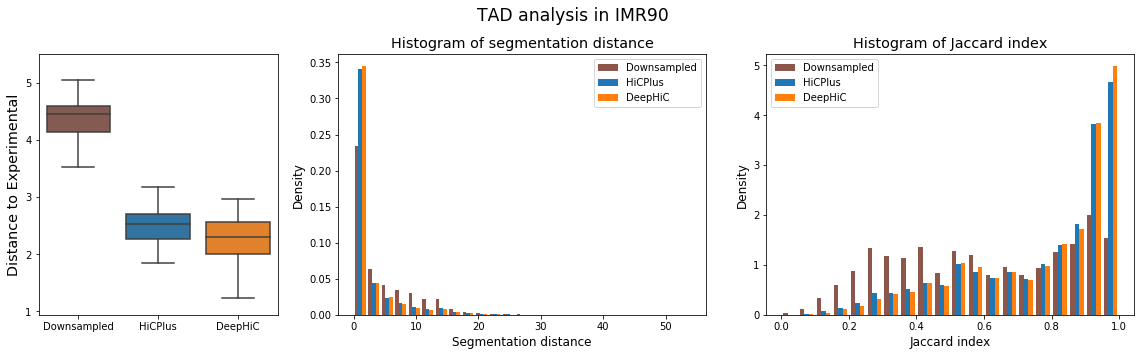

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5), gridspec_kw = {'width_ratios':[1.3, 2, 2]})

pal = {'Downsampled': 'C5', 'HiCPlus': 'C0', 'DeepHiC': 'C1'}
sns.boxplot(x='label', y='data', data=data_pd, ax=ax[0], fliersize=0, palette=pal)
# ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('Distance to Experimental', fontsize='x-large')
# y_max = 3.3
# y_min = 0.5
# ax[0].annotate("", xy=(1, y_max), xycoords='data',
#            xytext=(2, y_max), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=0.2"))
# ax[0].text(1.5, y_max + abs(y_max - y_min)*0.1, "*",
#        horizontalalignment='center',
#        verticalalignment='center')

# y_max = 1.3
# y_min = 0.1
# ax[0].annotate("", xy=(0, y_max), xycoords='data',
#            xytext=(2, y_max), textcoords='data',
#            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                            connectionstyle="bar,fraction=-0.1"))
# ax[0].text(1, y_max - abs(y_max - y_min)*0.1, "****",
#        horizontalalignment='center',
#        verticalalignment='center')


plot_hists(ax[1], down_dists_all, plus_dists_all, deep_dists_all, bins=25, 
           xlabel='Segmentation distance', ylabel='Density', 
           title='Histogram of segmentation distance')

plot_hists(ax[2], down_jacrd_all[:,1], plus_jacrd_all[:,1], deep_jacrd_all[:,1], bins=20, 
           xlabel='Jaccard index', ylabel='Density', 
           title='Histogram of Jaccard index')
fig.tight_layout()
plt.subplots_adjust(top=0.85)
fig.suptitle('TAD analysis in IMR90', fontsize='xx-large')
svg_file = os.path.join(work_dir, f'supp_fig_tad_imr90.svg')
eps_file = os.path.join(work_dir, f'supp_fig_tad_imr90.eps')
fig.savefig(svg_file, format='svg')
fig.savefig(eps_file, format='eps')

In [58]:
stats.ranksums(down_dist_mean, deep_dist_mean)

RanksumsResult(statistic=5.744940713710297, pvalue=9.1953198413831e-09)

In [59]:
stats.ranksums(plus_dist_mean, deep_dist_mean)

RanksumsResult(statistic=1.4609505065458306, pvalue=0.14402902450712382)